# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (201, 201)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

Allocating memory for src ((510, 1))
Allocating memory for src_coords ((1, 2))


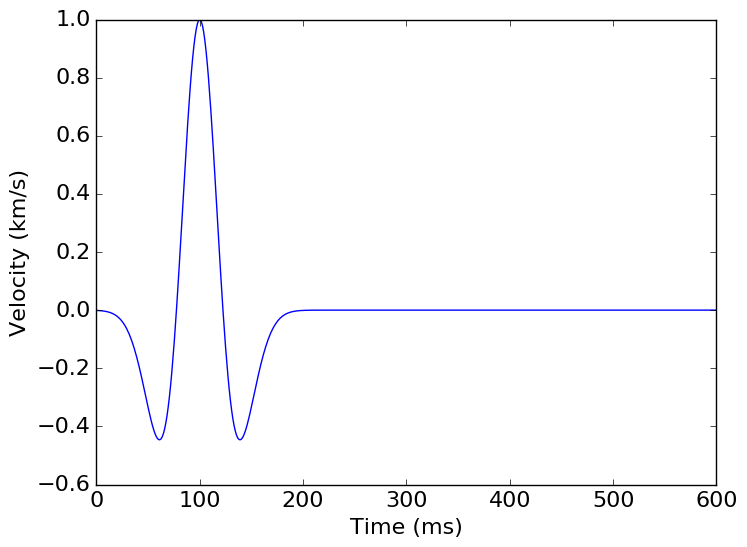

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = RickerSource(name='src', grid=grid, f0=0.01, time=time)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
vx= TimeFunction(name='vx', grid=grid, staggered=(0, 1, 0))
vz = TimeFunction(name='vz', grid=grid, staggered=(0, 0, 1))
txx = TimeFunction(name='txx', grid=grid)
tzz = TimeFunction(name='tzz', grid=grid)
txz = TimeFunction(name='txz', grid=grid, staggered=(0, 1, 1))

# And finally we create the discretized/indexed symbols
VX = vx.indexed
VZ = vz.indexed
TXX = txx.indexed
TZZ = tzz.indexed
TXZ = txz.indexed

In [5]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_vx = src.inject(field=vx, expr=src)
src_vz = src.inject(field=vz, expr=src)
src_xx = src.inject(field=txx, expr=src)
src_zz = src.inject(field=tzz, expr=src)
src_xz = src.inject(field=txz, expr=src)

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density
rox = 1/density * dt/x.spacing
roz = 1/density * dt/z.spacing
mu = cs2*ro
l2m = cp2*ro * dt/x.spacing
lam = (cp2*ro - 2*mu) * dt/x.spacing
mul = cs2*ro * dt/x.spacing  

##########################################
### fdelmodc reference implementation  ###
##########################################

# vx[ix*n1+iz] -= rox[ix*n1+iz]*(c1*(txx[ix*n1+iz] - txx[(ix-1)*n1+iz] + txz[ix*n1+iz+1] - txz[ix*n1+iz]) +
#                                c2*(txx[(ix+1)*n1+iz] - txx[(ix-2)*n1+iz] + txz[ix*n1+iz+2] - txz[ix*n1+iz-1]));
u_vx = Eq(vx.forward, vx - rox * (c1*(TXX[t, x, z] - TXX[t, x-1, z] + TXZ[t, x, z+1] - TXZ[t, x, z])
                               +  c2*(TXX[t, x+1, z] - TXX[t, x-2, z] + TXZ[t, x, z+2] - TXZ[t, x, z-1])))

# vz[ix*n1+iz] -= roz[ix*n1+iz]*(c1*(tzz[ix*n1+iz] - tzz[ix*n1+iz-1] + txz[(ix+1)*n1+iz] - txz[ix*n1+iz])  +
#                                c2*(tzz[ix*n1+iz+1] - tzz[ix*n1+iz-2] + txz[(ix+2)*n1+iz] - txz[(ix-1)*n1+iz]));
#u_vz = Eq(vz.forward, vz - roz * (c1*(TZZ[t, x, z] - TZZ[t, x, z-1] + TXZ[t, x+1, z] - TXZ[t, x, z])
#                               +  c2*(TZZ[t, x, z+1] - TZZ[t, x, z-2] + TXZ[t, x+2, z] - TXZ[t, x-1, z])))
u_vz = Eq(vz.forward, vz - roz * (c1*(TZZ[t, x, z] - TZZ[t, x, z-1] + TXZ[t, x+1, z] - TXZ[t, x, z])
                               +  c2*(TZZ[t, x, z+1] - TZZ[t, x, z-2] + TXZ[t, x+2, z] - TXZ[t, x-1, z])))

# dvx = c1*(vx[(ix+1)*n1+iz] - vx[ix*n1+iz]) + c2*(vx[(ix+2)*n1+iz] - vx[(ix-1)*n1+iz]);
# dvz = c1*(vz[ix*n1+iz+1]   - vz[ix*n1+iz]) + c2*(vz[ix*n1+iz+2]   - vz[ix*n1+iz-1]);
DVX = c1*(VX[t+1, x+1, z] - VX[t+1, x, z]) + c2*(VX[t+1, x+2, z] - VX[t+1, x-1, z])
DVZ = c1*(VZ[t+1, x, z+1] - VZ[t+1, x, z]) + c2*(VZ[t+1, x, z+2] - VZ[t+1, x, z-1])
# txx[ix*n1+iz] -= l2m[ix*n1+iz]*dvx + lam[ix*n1+iz]*dvz;
# tzz[ix*n1+iz] -= l2m[ix*n1+iz]*dvz + lam[ix*n1+iz]*dvx;
u_txx = Eq(txx.forward, txx - l2m * DVX - lam * DVZ)
u_tzz = Eq(tzz.forward, tzz - l2m * DVZ - lam * DVX)

# txz[ix*n1+iz] -= mul[ix*n1+iz]*(c1*(vx[ix*n1+iz] - vx[ix*n1+iz-1] + vz[ix*n1+iz] - vz[(ix-1)*n1+iz]) +
#                                 c2*(vx[ix*n1+iz+1] - vx[ix*n1+iz-2] + vz[(ix+1)*n1+iz] - vz[(ix-2)*n1+iz]) );
u_txz = Eq(txz.forward, txz - mul * (c1*(VX[t+1, x, z] - VX[t+1, x, z-1] + VZ[t+1, x, z] - VZ[t+1, x-1, z])
                                  +  c2*(VX[t+1, x, z+1] - VX[t+1, x, z-2] + VZ[t+1, x+1, z] - VZ[t+1, x-2, z])))


In [6]:
#op = Operator(src_vx + src_vz + [u_vx, u_vz] + src_xx + src_zz + src_xz + [u_txx, u_tzz, u_txz], dse=None, dle=None)

op = Operator(src_xx + src_zz + [u_vx, u_vz, u_txx, u_tzz, u_txz], dse=None, dle=None)
#print(op.ccode)

In [7]:
# The end values are fucking ridiculous...!
# Apparently the argument engine always ADDS stencil offsets, even to the end vars!
args = {'t': nt, 'time': nt, 'x_s': 2, 'x_e': shape[0]-8, 'z_s': 2, 'z_e':shape[1]-8}
#print(args)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

#print(op.arguments(**args))

op(**args)

Allocating memory for vx ((2, 200, 201))
Allocating memory for vz ((2, 201, 200))
Allocating memory for txx ((2, 201, 201))
Allocating memory for tzz ((2, 201, 201))
Allocating memory for txz ((2, 200, 200))
GNUCompilerNoAVX: compiled /var/folders/z0/tqrtpj3j5lz5vmpm09lx4mbw0000gp/T/devito-I6lops/d7bd8c72bc6a60ebfeae2ddbfff8129a00cd1137.c [0.35 s]
Section section_0<510,1> with OI=3.11 computed in 0.000 s [1.81 GFlops/s]
Section main<510,191,191> with OI=2.25 computed in 0.938 s [1.86 GFlops/s, 0.02 GPts/s]


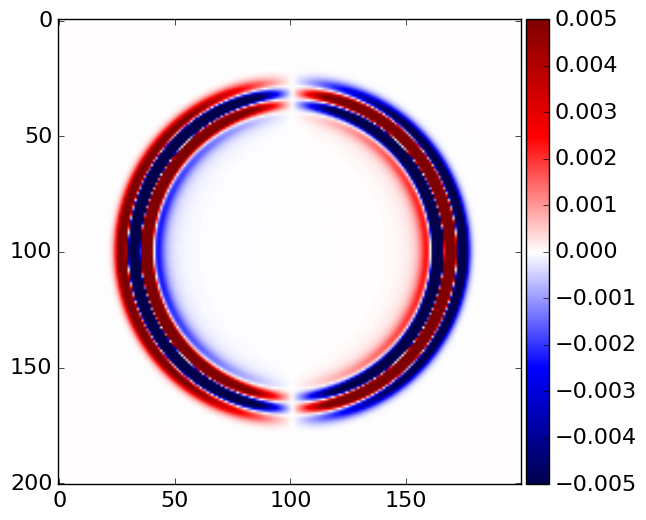

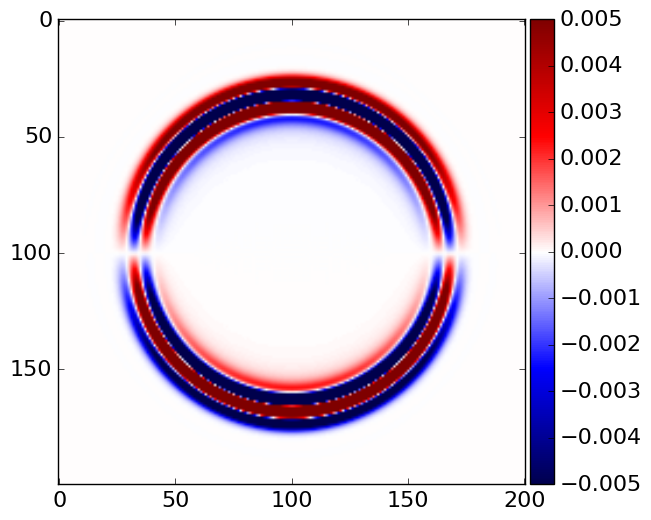

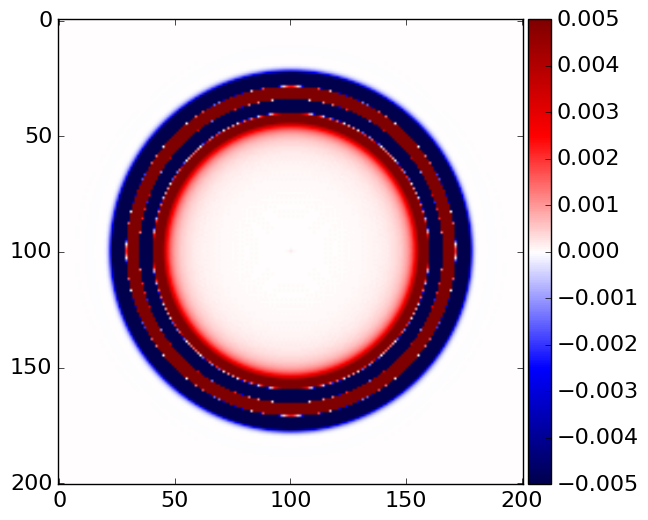

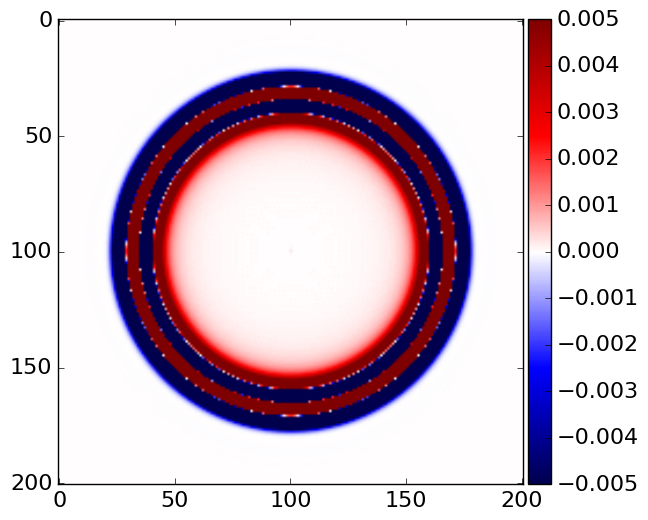

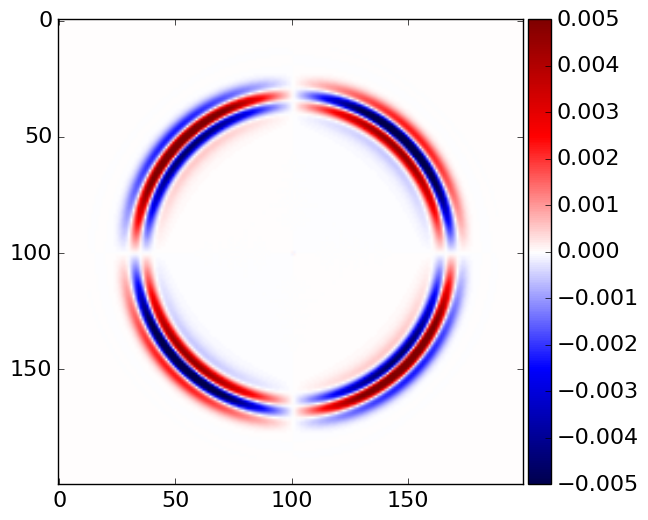

In [8]:
# Let's see what we got....
plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")